<a href="https://colab.research.google.com/github/ahhyun-moon/cs-gy-6613-assignments/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
# 1. Env setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Read data in google drive
# https://www.kaggle.com/competitions/avazu-ctr-prediction/data
df = pd.read_csv('/content/drive/MyDrive/avazu-ctr-prediction/train.gz'\
                 ,compression='gzip',nrows=1000000)

# First remove anonymized columns and id as we don't have further details to analyze.
to_drop = ['id','C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
clean_df = df.drop(to_drop, axis=1)

# Convert YYMMDDHH data to hour value
clean_df['hour'] = clean_df['hour'].map(lambda x: datetime.strptime(str(x),"%y%m%d%H"))
clean_df['hour'] = clean_df['hour'].map(lambda x:  x.hour)


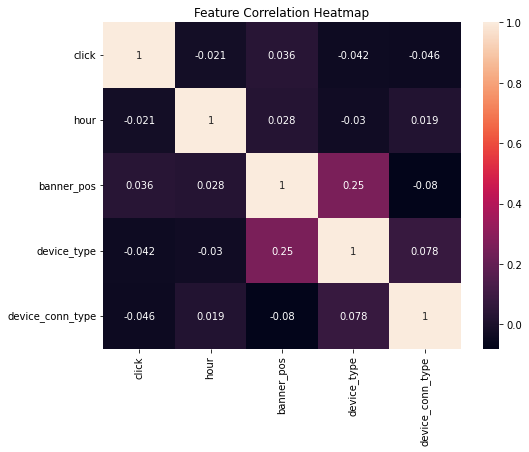

In [192]:
# 2-1. Data preprocessing

### Assumptions:
# The target variable (click) follows Bernoulli Distribution which has 2 outcomes (0/1).
# Therefore, we can use logistic regression model to classify the target in 0 or 1.

# Create 'features' dataframe by excluding target variable (click)
features = clean_df.drop(['click'], axis=1)

# Show correlations as heatmap to find relevant columns.
plt.figure(figsize=(8,6))
plt.title("Feature Correlation Heatmap")
sns.heatmap(clean_df.corr(), annot=True)
plt.show()

# Drop additional columns that have low correlation.
features = features.drop(['site_id', 'site_domain', 'site_category', 'app_id'
,'app_domain', 'app_category','device_ip', 'device_id','device_model'], axis=1)

### Now we have target and features as below:
# Target variable: 'click'
# Continuous Feature: 'hour'
# Discrete Features: 'banner_pos', 'device_type', 'device_conn_type'

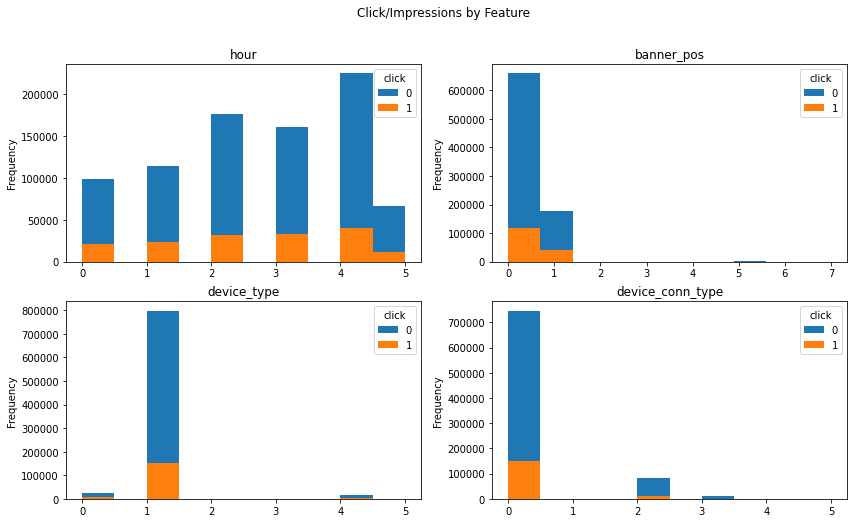

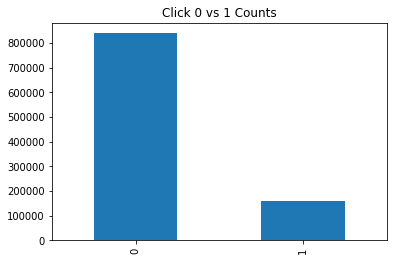

In [222]:
# 2-1. Data preprocessing

### Experiments:
fig,ax=plt.subplots(2,2,figsize=(14,8))
fig.suptitle("Click/Impressions by Feature")
clean_df.pivot(columns='click', values='hour')\
        .plot.hist(ax=ax[0,0], title='hour')
clean_df.pivot(columns='click', values='banner_pos')\
        .plot.hist(ax=ax[0,1], title='banner_pos')
clean_df.pivot(columns='click', values='device_type')\
        .plot.hist(ax=ax[1,0], title='device_type')
clean_df.pivot(columns='click', values='device_conn_type')\
        .plot.hist(ax=ax[1,1], title='device_conn_type')
plt.show()

# We can see that data is highly imbalance. 
# Almost 85% of click values are 0 and 15% values are 1.
clean_df.click.value_counts().plot(kind='bar')
plt.title("Click 0 vs 1 Counts")
plt.show()

In [223]:
# 2.2 Data standardizing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Using train_test_split, the dataset is broken into two parts in a ratio of 70:30,
# which means 70% data will be used for model training and 30% for model testing.
X_train, X_test, y_train, y_test\
= train_test_split(features, clean_df['click'], test_size=0.3, random_state = 15)

# Randomly undersample the training data to avoid data imbalance.
underSample = RandomUnderSampler(sampling_strategy=1)   
X_smote, y_smote = underSample.fit_resample(X_train, y_train)

# StandardScaler standardizes feature values by removing the mean and scaling to unit variance,
# so that each feature will have mean of 0 and standard deviation of 1.
# z = (x - u) / s
# Difference in scale can affect the step size of the gradient descent.
# It's not necessary to scale the output data as it is binary and won't affect the gradient descent. 
scaler = StandardScaler()
x_train_standard = scaler.fit_transform(X_smote)
x_test_standard = scaler.transform(X_test)  

In [214]:
# 3. Logistic Regression
from sklearn.linear_model import LogisticRegression

# Logistic Regression fits the data to sigmoid(z) = 1/(1 + exp(-z)), 
# by taking an instance x and calculating the likelihood of a binary outcome occurring as y.
# Then we train the model with SGD and binary cross entropy. 
# Binary cross entropy tells how far each output is from actual result. 
# SGD iteratively updates the model by looking at the binary cross entropy(cost).
lr = LogisticRegression()
lr.fit(x_train_standard, y_smote)

# From the score, we can assume the model is underfitting.
# The model is too simple and unable to capture the relationship 
# between its input features and the target values. 
# To improve the model, we can improve feature selection, increase training,
# and add complexity by regularization.  
print("Score: ", lr.score(x_test_standard, y_test))

Score:  0.5892966666666667


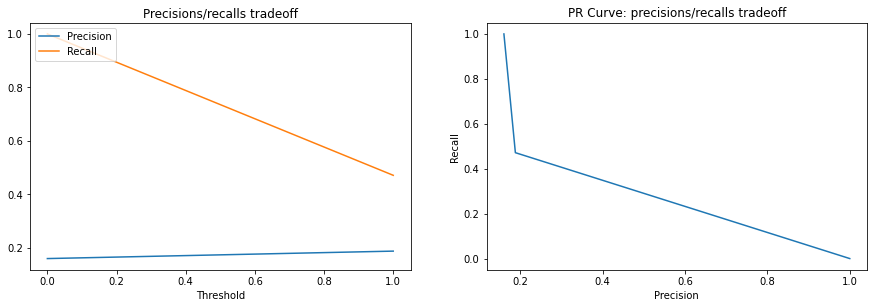

In [227]:
# 4. Performance Results
from sklearn.metrics import precision_recall_curve

# Y prediction on x_test_standard, based on the model. 
y_pred = lr.predict(x_test_standard)

# Draw precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

# Precision = number of true positives / (true positives + false positives)
# Represents how well the model predicts the positive class.
# Recall = number of true positives / (true positives + false negatives)
# Represents sensitivity. 
# If you increase precision, it will reduce recall, and vice versa.
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.title("Precisions/recalls tradeoff")
plt.subplot(2, 2, 2)
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR Curve: precisions/recalls tradeoff");